In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from utils import *

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [8]:
df = load_csv('dataset_3')

# Figure 1
<a id='fig1'></a>

Fig 1 from the paper is recreated below. Based on the shape of the chart it appears Saturday was used as the weekly anchor.

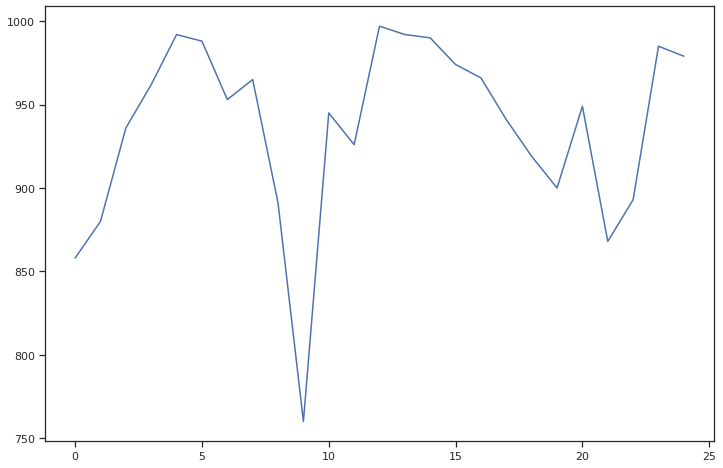

In [9]:
fig1 = df.resample('W-SAT', on='entry_date').count().sort_index()['patient_id']
fig1 = fig1.reset_index()
fig1.patient_id.plot();

# Table 2

_The caption mentions Table 2 is dataset 2 filtered to a 25 week period which is actually dataset 3._

In [10]:
days = ['Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']

week_data = df.resample('D', on='entry_date').count().sort_index()['patient_id'].reset_index()

week_data['day'] = pd.Series(days * int(len(week_data)/7))

# Set week number from 1 - 25
week_data['week'] = (week_data.entry_date + np.timedelta64(1, 'D')).dt.isocalendar().week # Add a Day as Israeli week starts on a Sunday
week_map = {v: k for (k, v) in enumerate(week_data.week.unique(), start=1)}
week_data['week'] = week_data['week'].apply(lambda x: week_map[x])

week_data['day_no'] = week_data.day.apply(lambda x: days.index(x))

week_data = week_data.rename({'patient_id': 'arrivals'}, axis=1).drop('entry_date', axis=1)

In [11]:
# Prepare table for display
tab2 = week_data.pivot(index='week', columns='day', values='arrivals')[days]

# Perform calcs on Days
_totals = tab2.sum(axis=1)
_mean = tab2.mean(axis=1).round(2)

# tab2 = week_data.copy()
tab2['Total'] = _totals
tab2['Mean'] = _mean

totals = pd.DataFrame([
    tab2.sum(axis=0),
    tab2.mean(axis=0).round(2),
    tab2.var(axis=0).round(2),
]).drop('Mean', axis=1)
totals['name'] = ['Total', 'Mean', 'Var.']
totals = totals.set_index('name')

tab2 = pd.concat([tab2, totals], sort=False)

In [12]:
tab2.fillna('')

,Sun.,Mon.,Tue.,Wed.,Thu.,Fri.,Sat.,Total,Mean
1,150.00,147.00,132.00,107.00,123.00,100.00,99.00,858.00,122.57
2,143.00,147.00,127.00,138.00,121.00,101.00,103.00,880.00,125.71
3,162.00,155.00,147.00,136.00,144.00,94.00,98.00,936.00,133.71
4,186.00,155.00,135.00,136.00,119.00,100.00,131.00,962.00,137.43
5,164.00,171.00,149.00,146.00,142.00,110.00,110.00,992.00,141.71
6,175.00,144.00,157.00,136.00,156.00,115.00,105.00,988.00,141.14
7,181.00,157.00,140.00,109.00,145.00,114.00,107.00,953.00,136.14
8,176.00,145.00,139.00,150.00,126.00,127.00,102.00,965.00,137.86
9,171.00,160.00,125.00,137.00,137.00,77.00,84.00,891.00,127.29
10,134.00,127.00,119.00,115.00,95.00,88.00,82.00,760.00,108.57


## Dispersion

> By looking at the dispersion (ratio of the variance to the mean), we see that there is a moderate level of overdispersion for the daily totals compared to a Poisson process (where the dispersion is 1).

### Figure A

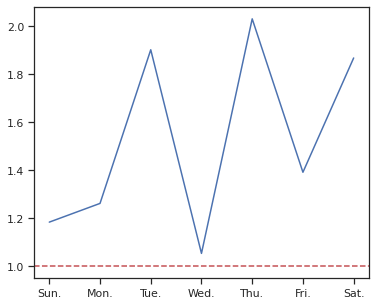

In [13]:
od = (tab2.loc['Var.'] / tab2.loc['Mean']).drop(['Total', 'Mean'])
od.plot(figsize=(6, 5))
plt.axhline(y=1, color='r', linestyle='--');

> if the arrival process were an NHPP, then the variance should be same as the mean and the standard deviation of the weekly total would be about √936 ≈ 31. Fig. 1 is roughly consistent with that Poisson property, except for week 10, which is about 5 standard deviations below the mean.

### Figure B

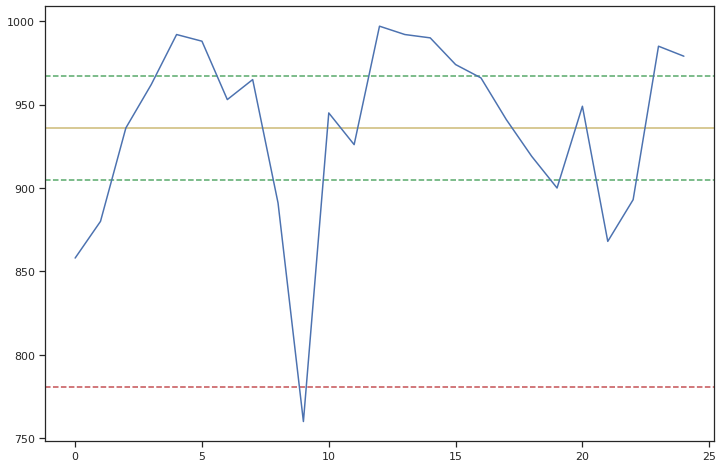

In [14]:
fig1 = df.resample('W-SAT', on='entry_date').count().sort_index()['patient_id']
fig1 = fig1.reset_index()

plt.axhline(y=936+31, color='g', linestyle='--');
plt.axhline(y=936, color='y');
plt.axhline(y=936-31, color='g', linestyle='--');

plt.axhline(y=936-(31*5), color='r', linestyle='--');

fig1.patient_id.plot();

## Statistical regression

The paper first discusses a two factor model:

$T (w, d) ≡ A + Bw + Cd + G(0, \sigma^2)$

> where ≡ denotes equality by definition, w represents the week and d is the day-of-week (DoW), while $G(0, \sigma^2)$ is a mean-0 Gaussian random variable with variance $\sigma^2$ (to be estimated) and A, B and C are constants. The week and the DoW are the two factors, so actually we have $w_i$'s as indicators for each week, $d_j$'s as indicators for each day-of-week and $B_i$'s, $C_j$'s accordingly. Because there is redundancy in model (1) since $\sum_i w_i = 1$ and $\sum^{7}_{j=1} d_j = 1$, we set $\sum B_i ≡ 0$ and $\sum C_j ≡ 0$, so that A gives the average daily total number of arrivals for all days.

> $A$ gives the average daily total number of arrivals for all days.

In [15]:
A = round(week_data.arrivals.mean(), 3)  # the average daily total number of arrivals for all days
A

133.766

In [16]:
wd = week_data.copy()
wd['y'] = wd.arrivals - A # normalise y

res = smf.ols('y ~  C(week) + day', data=wd).fit()

# Table 3

ANOVA (analysis of variance) is used to test the variance between multiple groups. 

An excellent introduction is given in Armstrong, R. A., S. V. Slade, and F. Eperjesi. ‘An Introduction to Analysis of Variance (ANOVA) with Special Reference to Data from Clinical Experiments in Optometry’. Ophthalmic and Physiological Optics 20, no. 3 (4 May 2000): 235–41. https://doi.org/10.1016/S0275-5408(99)00064-2.

In [17]:
(sm.stats.anova_lm(res)
   .reset_index()
   .rename({'index': 'Factor', 'sum_sq': 'Sum of square', 'mean_sq': 'Mean sum of square', 'F': 'F statistics', 'PR(>F)': 'P-value'}, axis=1)
   .fillna(''))

,Factor,df,Sum of square,Mean sum of square,F statistics,P-value
0,C(week),24.0,10666.251429,444.427143,2.75117,0.000110105
1,day,6.0,62893.234286,10482.205714,64.8888,1.6626e-38
2,Residual,144.0,23261.908571,161.541032,,


# Table 4

It then goes on to discuss a single factor model based on DoW ($d$) which is used over the two factor version, so that is what is recreated in detail below.

$T (d) ≡ A + Cd + G(0, \sigma^2)$

### Regression Coefficents

To determine the regression coefficents we use a linear regression model. 


The days are "one-hot" encoded, they are converted to integers but categorization is kept. Essentially each day is reperesented by a different row from the identity matrix so we get an individual co-efficient for each day.

$ y = A + C_1x_1 + C_2x_2 + C_3x_3 + ... + C_7x_7 $ 

Sunday becomes $ y = A + C_1(1) + 0 $, Saturday becomes $ y = A + 0 + C_7(1) $ etc.


We also normalise the arrivals data by subtracting the mean, $A$

In [18]:
# Encode days, X
ohe = OneHotEncoder(categories='auto')

X = ohe.fit_transform(
    week_data.day_no.values.reshape(-1, 1) # day_no is used rather than day to preserve ordering
).toarray() 

# Equivalent to 
# ident_matrix = np.eye(7)
# X = week_data.day_no.apply(lambda no: ident_matrix[no]).values

We use linear algebra to perform the regression and calculate the coefficient estimates ($a$) for each day.

In [19]:
coeffs = np.linalg.inv(X.T @ X) @ X.T @ (week_data.arrivals - A)
for day, c in zip(days, coeffs):
    print(f'{day}: {c:.3f}')

Sun.: 28.234
Mon.: 14.634
Tue.: 11.274
Wed.: -1.366
Thu.: -0.526
Fri.: -23.886
Sat.: -28.366


We can now use our coefficents to make predictions, $\hat{y}$, for a week

In [20]:
yhat = (X @ coeffs.T) + A

And we can calculate the standard error using:
    
$SE = \sqrt{\sum{\frac{(\hat{y} - y)^2}{N - p}}}$

In [21]:
y = week_data.arrivals

In the paper the estimated variance is given as $\sigma^2 = 202$, our calculation is below:

In [22]:
N = len(y)
p = len(days)

residuals = y.values - yhat
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)

print(f'sigma squared = {sigma_squared_hat:.0f}')

sigma squared = 202


And $D$, the dispersion (variance-to-mean ratio) is given as: 

$D \equiv \frac{\sigma^2}{\hat{m}} \equiv \frac{202.0}{133.8} = 1.51$

Where $\hat{m}$ is the estimated mean, $A$

In [23]:
print(f'D = {sigma_squared_hat/A:.2f}')

D = 1.51


### Figure C

We can see the predictions give us a non-straight line fit

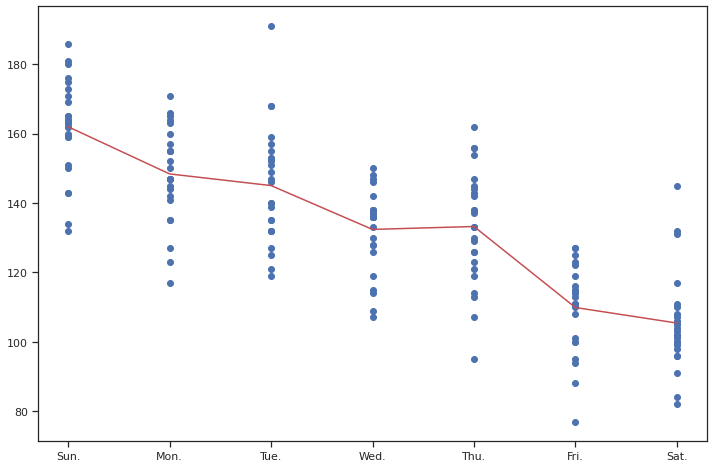

In [24]:
plt.scatter(week_data.day.values, week_data.arrivals)
plt.plot(days, yhat[:7], color='r');

### Figure D

Boxplot of errors

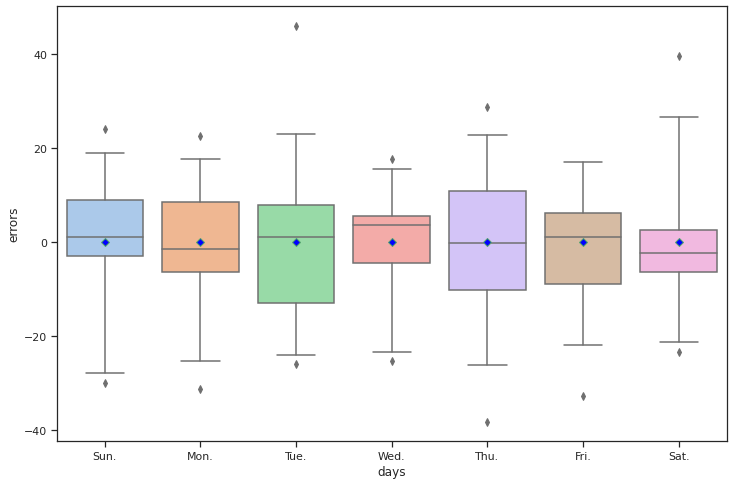

In [25]:
es = pd.DataFrame({'days': week_data.day.values, 'errors': residuals})
sns.boxplot(
    x="days", y="errors", data=es, 
    showmeans=True, meanprops={"marker":"D", "markerfacecolor":"blue"}, 
    whis=[1, 99], palette="pastel"
);

Finally, the standard errors are calculated as in table 4.

In [33]:
X.nrows

AttributeError: 'numpy.ndarray' object has no attribute 'nrows'

In [19]:
all_se = np.linalg.inv(X.T @ X) * sigma_squared_hat

for day, p_ in zip(days, range(p)):
    standard_error = all_se[p_, p_] ** 0.5
    print(f"SE({day}): {standard_error:.3f}")

SE(Sun.): 2.842
SE(Mon.): 2.842
SE(Tue.): 2.842
SE(Wed.): 2.842
SE(Thu.): 2.842
SE(Fri.): 2.842
SE(Sat.): 2.842


These values **do not** match those given in Table 4.

However Table 4 also contains an entry for $A$, the intercept. Errors are recalculated to include the intercept.

In [18]:
Xi = X.copy()
Xi[:, 0] = 1

In [19]:
names = ['intercept'] + days[:-1]

all_se = np.linalg.inv(Xi.T @ Xi) * sigma_squared_hat

std_errs = []
for day, p_ in zip(names, range(p)):
    standard_error = all_se[p_, p_] ** 0.5
    std_errs.append(standard_error)
    print(f"SE({day}): \t {standard_error:.3f}")

std_errs.append(standard_error) # Manually add in Saturday

SE(intercept): 	 2.842
SE(Sun.): 	 4.019
SE(Mon.): 	 4.019
SE(Tue.): 	 4.019
SE(Wed.): 	 4.019
SE(Thu.): 	 4.019
SE(Fri.): 	 4.019


Finally, we can recreate Table 4.

In [20]:
tab4 = pd.DataFrame(
    data=[('A', A, std_errs[0])] + list(zip(days, coeffs, std_errs[1:])),
    columns=['Coefficients', 'Estimates', 'SE']
)
tab4.SE = tab4.SE.round(3)
tab4.style.hide_index()

Coefficients,Estimates,SE
A,133.766000,2.842000
Sun.,28.234000,4.019000
Mon.,14.634000,4.019000
Tue.,11.274000,4.019000
Wed.,-1.366000,4.019000
Thu.,-0.526000,4.019000
Fri.,-23.886000,4.019000
Sat.,-28.366000,4.019000


### Python libraries

As a learning excercise, the regression was also performed using a number of Python libraries.

#### Scikit Learn

Coefficients agree with the Paper but Scikit provides no info on residuals etc.

In [21]:
lr = LinearRegression(fit_intercept=True)  

lr.fit(X, week_data.arrivals) # Arrivals are normalised by sci kit leanr

pd.DataFrame(
    data=[('A', lr.intercept_)] + list(zip(days, lr.coef_)), 
    columns=['Coefficients', 'Estimates']
)

,Coefficients,Estimates
0,A,133.765714
1,Sun.,28.234286
2,Mon.,14.634286
3,Tue.,11.274286
4,Wed.,-1.365714
5,Thu.,-0.525714
6,Fri.,-23.885714
7,Sat.,-28.365714


#### Statsmodel

Another library, statsmodel is used. The coefficents match the paper, however the SE does not.

In [65]:
#
# Matching Coeffs
#
wd = week_data.copy()
wd['y'] = wd.arrivals - A

reg = smf.ols('y ~ day - 1', data=wd).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     51.90
Date:                Wed, 30 Sep 2020   Prob (F-statistic):           8.69e-36
Time:                        11:19:45   Log-Likelihood:                -709.20
No. Observations:                 175   AIC:                             1432.
Df Residuals:                     168   BIC:                             1455.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day[Fri.]    -23.8860      2.842     -8.404      0.000     -29.497     -18.275
day[Mon.]     14.6340      2.842      5.149      0.000       9.023      20.245
day[Sat.]    -28.3660      2.842     -9.980      0.000     -33.977     -22.755
day[Sun.]     28.2340      2.842      9.934      0.000      22.623      33.845
day[Thu.]     -0.5260      2.842     -0.185      0.853      -6.137       5.085
day[Tue.]     11.2740      2.842      3.967      0.000       5.663      16.885
day[Wed.]     -1.3660      2.842     -0.481      0.631      -6.977       4.245
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.209
Skew:                          -0.031   Prob(JB):                        0.546
Kurtosis:                       3.403   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we include the intercept in the model, the standard errors now match the paper but the estimates do not.

In [66]:
#
# Matching Errors
#
regi = smf.ols('y ~ day', data=wd).fit()
regi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     51.90
Date:                Wed, 30 Sep 2020   Prob (F-statistic):           8.69e-36
Time:                        11:19:47   Log-Likelihood:                -709.20
No. Observations:                 175   AIC:                             1432.
Df Residuals:                     168   BIC:                             1455.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -23.8860      2.842     -8.404      0.000     -29.497     -18.275
day[T.Mon.]    38.5200      4.019      9.583      0.000      30.585      46.455
day[T.Sat.]    -4.4800      4.019     -1.115      0.267     -12.415       3.455
day[T.Sun.]    52.1200      4.019     12.967      0.000      44.185      60.055
day[T.Thu.]    23.3600      4.019      5.812      0.000      15.425      31.295
day[T.Tue.]    35.1600      4.019      8.747      0.000      27.225      43.095
day[T.Wed.]    22.5200      4.019      5.603      0.000      14.585      30.455
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                1.209
Skew:                          -0.031   Prob(JB):                        0.546
Kurtosis:                       3.403   Cond. No.                         7.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fig 2

Next two plots were created to provide supporting detail for the model. 

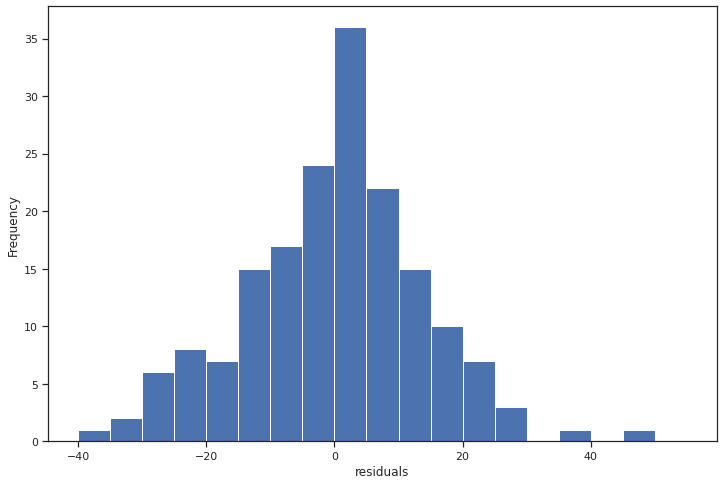

In [67]:
plt.hist(residuals, bins = range(-40, 60, 5)) 
plt.ylabel('Frequency')
plt.xlabel('residuals')
plt.show()

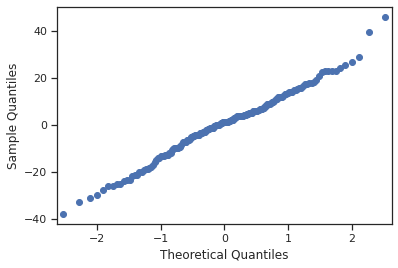

In [25]:
sm.qqplot(residuals);

# Fig 3

> We now estimate the time-varying arrival rate by computing hourly averages and using a piecewise-linear plot. Unlike most service systems, we find that it is important to take a week view as opposed to a day view. Thus, we combine all the 25 weeks and estimate the hourly arrival rate over a week, as is shown in Fig. 3.

In [26]:
hourly_data = (df
               .resample('H', on='entry_date')
               .count()
               .sort_index()['patient_id']
               .reset_index()
               .rename({'patient_id': 'arrivals'}, axis=1))

# dayofweek
# monday is 0, sunday is 6 but we want sunday is 0, monday is 1 for Israel
hourly_data['day'] = (hourly_data.entry_date.dt.dayofweek + 1) % 7
hourly_data['hour'] = hourly_data.entry_date.dt.hour

# Group by DoW and hour and calculate means
hourly_data = hourly_data.groupby(['day', 'hour']).mean().reset_index()

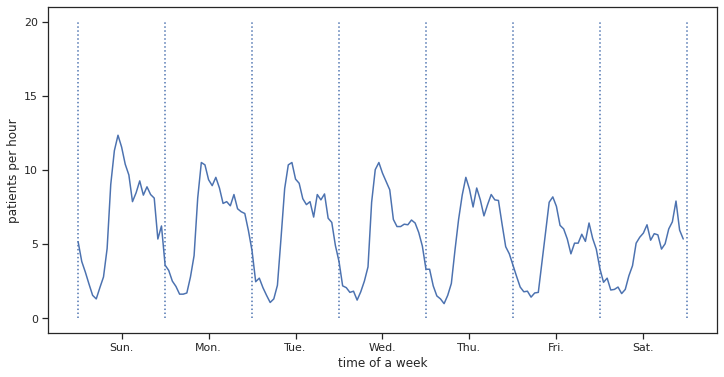

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_data.index, hourly_data.arrivals)

plt.xticks(range(12, len(hourly_data), 24), labels=days) # tick every 24 hours
plt.yticks(range(0, 25, 5))

for hour in list(range(0, len(hourly_data)+24, 24)):
    plt.vlines(hour, 0, 20, linestyles='dotted')

plt.ylabel('patients per hour')
plt.xlabel('time of a week');

# Fig 4

>  we can normalize the arrival rate by the daily totals; i.e., we divide the arrival rate in Fig. 3 by the average daily total arrivals of each day of week. Fig. 4 (left) shows the arrival rate after normalizing, while Fig. 4 (right) shows the corresponding estimated cumulative arrival rate function.

In [28]:
daily_means = week_data.groupby('day_no').mean()

In [29]:
nhd = hourly_data.copy()
def normalized(row):
    return row.arrivals / daily_means.loc[row.day].arrivals
    
nhd['normalized'] = nhd.apply(normalized, axis=1)

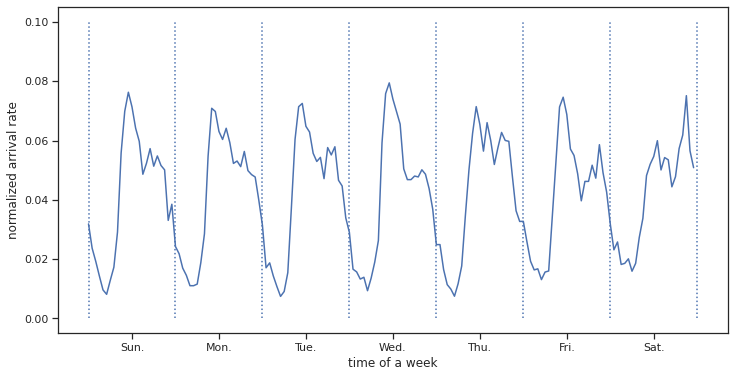

In [30]:
plt.figure(figsize=(12, 6))
nhd.normalized.plot()

plt.xticks(range(12, len(nhd), 24), labels=days) # tick every 24 hours

for hour in list(range(0, len(nhd)+24, 24)):
    plt.vlines(hour, 0, 0.1, linestyles='dotted')

plt.ylabel('normalized arrival rate')
plt.xlabel('time of a week');

In [31]:
nhd['normalized_cum_sum'] = nhd.groupby('day').normalized.cumsum()

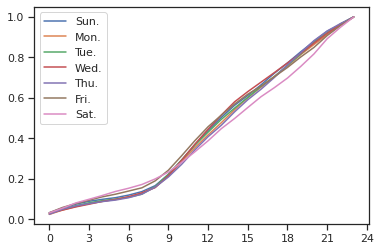

In [32]:
for day in range(7):
    plt.plot(range(0, 24), nhd[nhd.day == day].normalized_cum_sum)
plt.xticks(range(0, 27, 3))
plt.legend(days);

# Fig 5 (WIP)

> The index of dispersion for counts (IDC) is the ratio of the variance to the mean of the arrival counting process, as a function of time. Let A(t ) be the number of arrivals in interval [0, t ], so that {A(t ), : t ≥ 0} is the arrival counting process. Let Λ(t ) ≡ E[A(t )] and V(t) ≡ Var(A(t)) be the mean and variance functions. Then the IDC is I(t) ≡ V(t)/Λ(t), t ≥ 0.

![](figure_5.png)

In [33]:
hourly_counts = (df
               .resample('H', on='entry_date')
               .count()
               .sort_index()['patient_id']
               .reset_index()
               .rename({'patient_id': 'A'}, axis=1)
)

def get_t(entry_date):
#     days = (hourly_counts.entry_date.dt.dayofweek + 1) % 7
#     hours = hourly_counts.entry_date.dt.hour
    day = (entry_date.dayofweek + 1) % 7
    hour = entry_date.hour
    return f'{day}{hour}'


hourly_counts['t'] = hourly_counts.entry_date.apply(get_t)

hourly_counts = hourly_counts.set_index(hourly_counts.entry_date).drop('entry_date', axis=1)

hourly_counts.head()

,A,t
entry_date,,
2004-12-05 01:00:00,3,01
2004-12-05 02:00:00,5,02
2004-12-05 03:00:00,2,03
2004-12-05 04:00:00,2,04
2004-12-05 05:00:00,2,05


# Fig 6

> For managing ED’s, we wanted to investigate if this thinning might be time-dependent. Fig. 6 shows the estimated arrival rates of the admitted and non- admitted patients for a week.

In [34]:
def arrivals_per_hour(ds):
    return (ds.resample('H', on='entry_date')
              .count()
              .sort_index()['patient_id']
              .reset_index()
              .rename({'patient_id': 'arrivals'}, axis=1))    

In [35]:
def get_total_hourly_arrivals():
    "Read totals in from data set 3"
    ds = arrivals_per_hour(load_csv('dataset_3')).rename(columns={'arrivals': 'total'})
    ds['day'] = (ds.entry_date.dt.dayofweek + 1) % 7
    ds['hour'] = ds.entry_date.dt.hour
    # # Group by DoW and hour and calculate means
    ds = ds.groupby(['day', 'hour']).mean().reset_index()
    return ds.total

In [57]:
arrivals = arrivals_per_hour(load_csv('dataset_5')).rename(columns={'arrivals': 'admitted'})
arrivals['non_admitted'] = arrivals_per_hour(load_csv('dataset_6')).arrivals

arrivals['day'] = (arrivals.entry_date.dt.dayofweek + 1) % 7
arrivals['hour'] = arrivals.entry_date.dt.hour
# Group by DoW and hour and calculate means
arrivals = arrivals.groupby(['day', 'hour']).mean().reset_index()
arrivals['totals'] = get_total_hourly_arrivals()

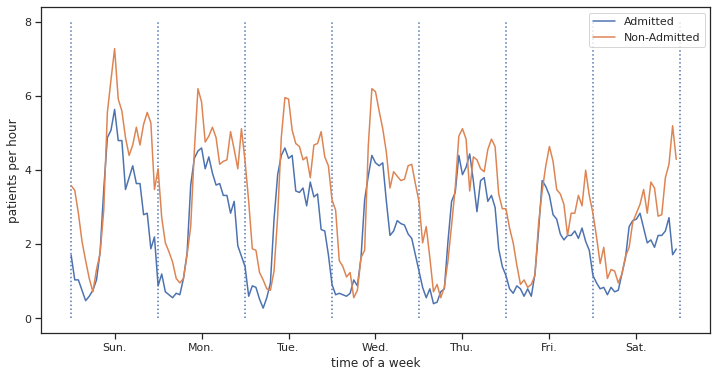

In [59]:
plt.figure(figsize=(12, 6))

plt.plot(arrivals.index, arrivals.admitted, label="Admitted")
plt.plot(arrivals.index, arrivals.non_admitted, label="Non-Admitted")
plt.legend()

# Formatting
hours_in_a_wk = 24*7
plt.xticks(range(12, hours_in_a_wk, 24), labels=days) # tick every 24 hours at 12 o clock
plt.yticks(range(0, 10, 2))

for hour in list(range(0, hours_in_a_wk+24, 24)):
    plt.vlines(hour, 0, 8, linestyles='dotted')

plt.ylabel('patients per hour')
plt.xlabel('time of a week');

## Appendix Figure 15

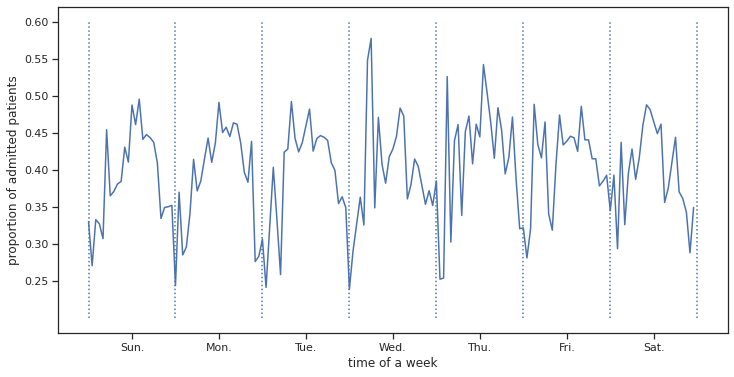

In [60]:
arrivals['p'] = arrivals.admitted / arrivals.totals

plt.figure(figsize=(12, 6))

plt.plot(arrivals.index, arrivals.p, label="p(t)")

# Formatting
hours_in_a_wk = 24*7
plt.xticks(range(12, hours_in_a_wk, 24), labels=days) # tick every 24 hours at 12 o clock
plt.yticks(np.arange(0.25, 1, step=0.05))

for hour in list(range(0, hours_in_a_wk+24, 24)):
    plt.vlines(hour, 0.20, 0.6, linestyles='dotted')

plt.ylabel('proportion of admitted patients')
plt.xlabel('time of a week');

# Figure 7

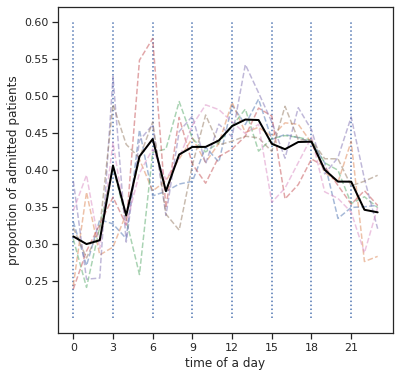

In [61]:
plt.figure(figsize=(6, 6))

hours = []
for i in range(0, 24):
    hour_data = arrivals[arrivals.hour == i]
    hours.append(np.mean(hour_data.p))
    
# Days    
for i in range(0, 7):
    day_data = arrivals[arrivals.day == i]
    plt.plot(day_data.hour, day_data.p, linestyle='dashed', alpha=0.5)

# Mean
plt.plot(day_data.hour, hours, linestyle='solid', color='black', linewidth=2.0)

# Formatting
plt.xticks(range(0, 24, 3)) # tick every 3 hours
plt.yticks(np.arange(0.25, 1, step=0.05))

for hour in list(range(0, 24, 3)):
    plt.vlines(hour, 0.20, 0.6, linestyles='dotted')

plt.ylabel('proportion of admitted patients')
plt.xlabel('time of a day');

> According to the above figure, we fit a quadratic function for $p(t)$ using the method of least squares with a fixed vertex at 2:30 p.m.. The result is shown in the figure below.

The expression of the fitted function $\hat{p}(t)$ is

$$
\begin{split}
\hat{p}(t) & = f(x) \\
           & = −0.001082x^2 + 0.02914x + 0.2548015 \\
           & = −0.001082(x − 13.5)^2 + 0.451996 \\
\end{split}           
$$
where x = ((t − 1.5) mod 24) + 1.5 and t $\in$ [0, 24]

In [62]:
def p_hat(t):
    x = ((t - 1.5)) % 24 + 1.5
    return (-0.001082 * (x - 13.5)**2) + 0.451996

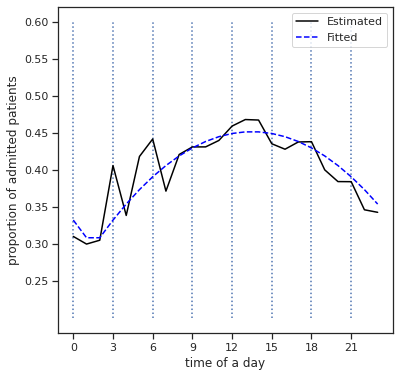

In [63]:
plt.figure(figsize=(6, 6))
    
# Estimated (Mean)
plt.plot(arrivals.hour.unique(), hours, linestyle='solid', color='black', label='Estimated')

# Quadratic function
plt.plot(arrivals.hour.unique(), list(map(p_hat, arrivals.hour.unique())), linestyle='--', color='blue', label='Fitted')

# Formatting
plt.legend()
plt.xticks(range(0, 24, 3)) # tick every 3 hours
plt.yticks(np.arange(0.25, 1, step=0.05))

for hour in list(range(0, 24, 3)):
    plt.vlines(hour, 0.20, 0.6, linestyles='dotted')

plt.ylabel('proportion of admitted patients')
plt.xlabel('time of a day');